In [53]:
# Based on https://pubs.aip.org/apl/article/93/5/051105/324815/Terahertz-conductivity-of-thin-metal-films

In [54]:
import astropy.constants as c
import astropy.units as u
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x78efa5b327d0>

In [55]:
# ------>|    |             |
#     <--| -> |             |
#        | <- | ----------> |
#     <- | -> |          <- | ------->
# Vacuum | Al |    HDPE     | Vacuum
#        |    |             |

In [56]:
# amplitude transmission: Eq. 1
def amp_transmission(f, h_film, d_substrate, t12, t23, t34, r12, r23, n2, n3):
    numer = (t12 * t23 * t34) * np.exp(1j * (2. * np.pi * h_film * f / c.c) * n2) * np.exp(1j * (2. * np.pi * d_substrate * f / c.c) * n3)
    denom = 1. + r12 * r23 * np.exp(2. * 1j * (2. * np.pi * h_film * f / c.c) * n2)
    return numer / denom

# https://en.wikipedia.org/wiki/Fresnel_equations#Complex_amplitude_reflection_and_transmission_coefficients
# assume normal incidence: all terms cos(\theta) = 1
def reflection(n_left, n_right):
    return ((n_left - n_right) / (n_left + n_right))

def transmission(n_left, n_right):
    return ((2. * n_left) / (n_left + n_right))

# thin film refractive index: Eq. 2
def n_metal(f, sigma):
    return ((1. + 1j) * np.sqrt(sigma / (4. * np.pi * c.eps0 * f))).decompose()

In [ ]:
f = np.linspace(0.5, 3.5) * u.THz

# Vacuum
n1 = 1.

# Aluminum
# Table I
h_sigma_al = np.array([36., 88., 152.]) * u.nm
sigma_al = np.array([17, 16, 22]) / u.uOhm / u.m # 295 K, evil paper does not use SI units and there is an implied 1/m in reported value
n_al = lambda f, h: n_metal(f, np.interp(h.to(u.nm), h_sigma_al, sigma_al))
n2 = (n_al(f, h_sigma_al[1])).decompose().value

# why do they quote n2(1.0THz) = 370? I get ~379. Scale to match the paper.
n2 *= (370 / 379.21)

# Si
n3 = 3.4175
d3 = 0.43 * u.mm

# Vacuum
n4 = 1.

In [58]:
n_al(1.0 * u.THz, h_sigma_al[1])

<Quantity 379.21079715+379.21079715j>

In [59]:
t = amp_transmission(
    f.to(u.Hz),
    h_sigma_al[1].to(u.m),
    d3.to(u.m),
    transmission(n1, n2),
    transmission(n2, n3),
    transmission(n3, n4),
    reflection(n1, n2),
    reflection(n2, n3),
    n2,
    n3
)

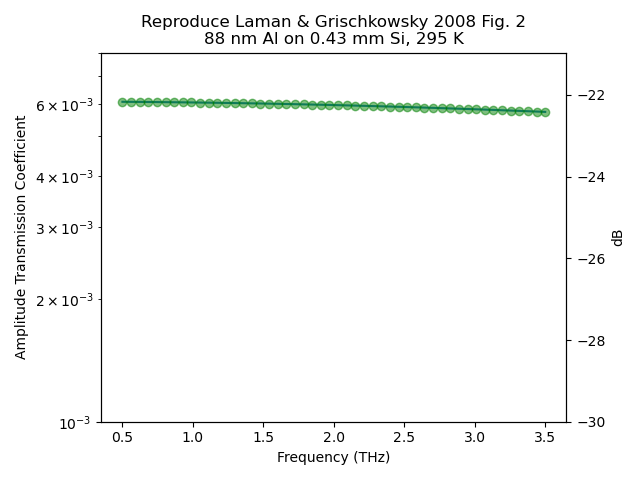

In [60]:
t_mag = np.abs(t.decompose())
ylim = (0.001, 0.008) # in terms of amplitude

fig, ax = plt.subplots()
ax.plot(f, t_mag)
ax.set_ylim(ylim[0], ylim[1])
ax.set_yscale('log')

ax_right = ax.twinx()
ax_right.scatter(f, 10 * np.log10(t_mag), color='g', alpha=0.5)
ax_right.set_ylim(10 * np.log10(ylim[0]), 10 * np.log10(ylim[1]))

ax_right.set_ylabel('dB')

ax.set_title('Reproduce Laman & Grischkowsky 2008 Fig. 2\n88 nm Al on 0.43 mm Si, 295 K')
ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('Amplitude Transmission Coefficient')

fig.tight_layout()

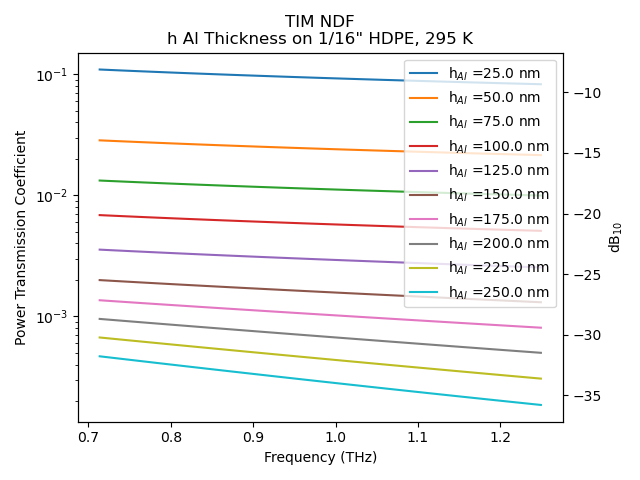

In [ ]:
lambd = np.linspace(420, 240) * u.um
f = (c.c / lambd).to(u.THz)
# HDPE
# refractive index and extinction factor of HDPE is ~frequency-independent from 40-200 um:
# Smith and Loewenstein 1975: HDPE; n,k 40.0–200 µm via https://refractiveindex.info/?shelf=organic&book=polyethylene&page=Smith
n3 = 1.518
# k3 = 0.0022
d3 = (1. / 16.) * 25.4 * u.mm

fig, ax = plt.subplots()
ax_right = ax.twinx()

for h in np.arange(25, 275, 25) * u.nm:
    n2 = (n_al(f, h)).decompose().value
    n2 *= (370 / 379.21)

    t = amp_transmission(
        f.to(u.Hz),
        h.to(u.m),
        d3.to(u.m),
        transmission(n1, n2),
        transmission(n2, n3),
        transmission(n3, n4),
        reflection(n1, n2),
        reflection(n2, n3),
        n2,
        n3
    )

    # https://en.wikipedia.org/wiki/Fresnel_equations
    t_mag_power = (n2 / n1) * (np.abs(t)**2)
    ax.plot(f, t_mag_power, label='h$_{Al}$ =' +f'{h}')
    ax_right.scatter(f, 10 * np.log10(t_mag_power), alpha=0.0)

ax.legend()
ax.set_yscale('log')
ax_right.set_ylabel('dB$_{10}$')

ax.set_title('TIM NDF\nh Al Thickness on 1/16" HDPE, 295 K')
ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('Power Transmission Coefficient')

fig.tight_layout()